In [71]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

# Shi-Tomasi's good features to track
an extension of the Harris corner detector <br/>
taken from [opencv doc](https://docs.opencv.org/4.x/d4/d8c/tutorial_py_shi_tomasi.html)

In [72]:
video_path = "videos/jog.mp4"
cap = cv.VideoCapture(video_path)

# take first frame of the video
ret,frame = cap.read()
frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
frame_gr = cv.cvtColor(frame, cv.COLOR_RGB2GRAY)
cap.release()

(np.float64(-0.5), np.float64(1279.5), np.float64(719.5), np.float64(-0.5))

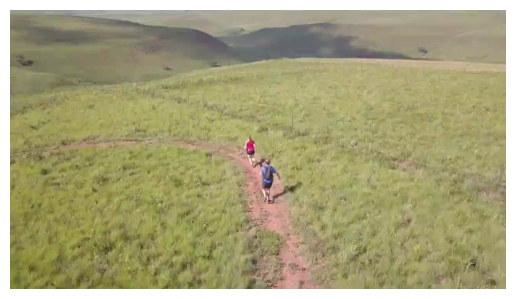

In [73]:
plt.imshow(frame)
plt.axis('off')

In [74]:
# From drotrack
def find_Shi_Tomasi_corners(first_frame, maxCorners = 100, qualityLevel = 0.2, minDistance = 7, blockSize = 7):
    # ShiTomasi corner detection
    # https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_shi_tomasi/py_shi_tomasi.html
    # Set parameters for 
    feature_params = dict(maxCorners=maxCorners, 
                          qualityLevel=qualityLevel, 
                          minDistance=minDistance, 
                          blockSize=blockSize)
    # Find inital corner locations
    corners = cv.goodFeaturesToTrack(first_frame, mask = None, **feature_params)
    return corners

In [75]:
def LKT_intialization(first_frame, x1, y1, x2, y2,
                      maxCorners = 100, 
                      qualityLevel = 0.5, 
                      minDistance = 1, 
                      blockSize = 3, padding = 0):
    
    qualityLevel = max(qualityLevel, 0.005)
    
    # ShiTomasi corner detection 
    first_frame_corners = find_Shi_Tomasi_corners(first_frame, maxCorners=maxCorners, qualityLevel=qualityLevel, minDistance=minDistance, blockSize=blockSize)

    corners = []
    for i in first_frame_corners:
        x,y = i.ravel()
        corners.append(list(i.ravel()))

    points = []

    for i in range(len(corners)):

        p_x = corners[i][0] #Current point x
        p_y = corners[i][1] #Current point y

        if ((p_x >= x1 and p_x < x2) and (p_y >= y1 and p_y < y2)):
            points.append(corners[i])

    if len(points) > 0:
        return np.array(points)
    else:
        maxCorners = maxCorners + 10; 
        qualityLevel = qualityLevel - 0.05; 
        minDistance = minDistance+1; 
        blockSize = blockSize+1; 
        padding = padding+1
        return LKT_intialization(first_frame, x1, y1, x2, y2,
                                 maxCorners, 
                                 qualityLevel, 
                                 minDistance, 
                                 blockSize, 
                                 padding)

In [ ]:
def otpical_flow_LKT(prev_frame, frame, prev_corners, scale):

    s = int(100*scale)
    if s < 15:
        s = 15
    if s > 30:
        s = 30

    m = int(s/2)*10
        
    # Set parameters for lucas kanade optical flow
    lucas_kanade_params = dict( winSize  = (s, s), # (int(500*scale), int(500*scale)), 
                                maxLevel = 10,
                                criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, m, m/100)
                               )
    # calculate optical flow
    current_corners, status, errors = cv.calcOpticalFlowPyrLK(prev_frame, frame,  prev_corners,  None, **lucas_kanade_params)
    
    return current_corners, status, errors

In [ ]:
corners_init = LKT_intialization(frame_gr, 0, 0, frame_gr.shape[1], frame_gr.shape[0], maxCorners = 100, qualityLevel = 0.2, minDistance = 7, blockSize = 7)
# Create a mask image for drawing purposes
mask = np.zeros_like(frame)
# Get frame width, height, and FPS for saving the output video
frame_height, frame_width = frame.shape[:2]
fps = cap.get(cv.CAP_PROP_FPS) * 3

# Define the codec and create VideoWriter object
fourcc = cv.VideoWriter_fourcc(*'mp4v')  # Use 'mp4v' codec for MP4 files
out = cv.VideoWriter('flow_output.mp4', fourcc, fps, (frame_width, frame_height))
old_gray = frame_gr

color = np.random.randint(0,255,(100,3))

In [ ]:
while True:
    ret, frame = cap.read()
    if not ret:
        print('No frames grabbed!')
        break

    # Convert frame to grayscale
    frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

    # Calculate optical flow
    p1, st, er = otpical_flow_LKT(old_gray, frame_gray, p0, scale=0.5)

    # Select good points
    if p1 is not None:
        good_new = p1[st == 1]
        good_old = p0[st == 1]

    # Draw the tracks
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.ravel()
        c, d = old.ravel()
        mask = cv.line(mask, (int(a), int(b)), (int(c), int(d)), color[i].tolist(), 2)
        frame = cv.circle(frame, (int(a), int(b)), 5, color[i].tolist(), -1)

    # Overlay the mask on the frame
    img = cv.add(frame, mask)

    # Write the frame to the output file
    out.write(img)

    # Update previous frame and points
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1, 1, 2)

# Release resources
cap.release()
out.release()
cv.destroyAllWindows()